In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import tensorflow as tf

import utils

/home/ifled/.pyenv/versions/3.6.3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
#SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/'
#WORK_DIRECTORY = 'data'
#IMAGE_SIZE = 28
#NUM_CHANNELS = 1
#PIXEL_DEPTH = 255
#NUM_LABELS = 10
#VALIDATION_SIZE = 5000  # Size of the validation set.
#SEED = 66478  # Set to None for random seed.
BATCH_SIZE = 64
NUM_EPOCHS = 100
EVAL_BATCH_SIZE = 64
EVAL_FREQUENCY = 100  # Number of steps between evaluations.
DATASET = 'cifar10'

NUM_UNROLL_STEPS = 5

### Like 2_stage/confnn_gated_cifar10.ipynb, but use architecture from tf baseline

In [5]:
# took architecture from here: https://github.com/tensorflow/models/blob/f798e4b5504b0b7ed08f7b7a03fc5a79f00b9f21/tutorials/image/cifar10/cifar10.py#L188

def model_step(input_images, prior, batch_size, training, num_labels, use_priors):
    """The Model definition."""
    inputs = input_images
    
    conv1 = tf.layers.conv2d(
        inputs=inputs,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[3, 3], strides=2, padding='same')
    
    norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')

    conv2 = tf.layers.conv2d(
        inputs=norm1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    
    norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')
    
    pool2 = tf.layers.max_pooling2d(inputs=norm2, pool_size=[2, 2], strides=2, padding='same')
    
    pool2_shape = pool2.get_shape()
    num_units_after_conv = pool2_shape[1] * pool2_shape[2] * pool2_shape[3]

    pool2_flat = tf.reshape(pool2, [-1, num_units_after_conv])
    
    if use_priors:
        projections = tf.layers.dense(inputs=prior, units=100, activation=tf.nn.relu)
        gates = tf.layers.dense(inputs=projections, units=num_units_after_conv, activation=tf.nn.sigmoid)
        
        gated = tf.multiply(pool2_flat, gates)
    else:
        gated = pool2_flat
    
    
    dense1 = tf.layers.dense(inputs=gated, units=384, activation=tf.nn.relu,
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(0.004))
    
    dense2 = tf.layers.dense(inputs=dense1, units=192, activation=tf.nn.relu,
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(0.004))

    logits = tf.layers.dense(inputs=dense2, units=num_labels)
    posteriors = tf.nn.softmax(logits)
    
    return logits, posteriors

def apply(input_images, training, train_labels_node, num_labels, use_priors):
    results = []
    loss = 0.0

    batch_size = input_images.get_shape()[0]
    priors = tf.ones((batch_size, num_labels)) / num_labels
    for step in range(NUM_UNROLL_STEPS):
        with tf.variable_scope('one_step', reuse=(step > 0)):
            logits, posteriors = model_step(input_images, priors, batch_size,
                                            training=training, num_labels=num_labels,
                                            use_priors=use_priors)
        priors = posteriors
        results.append((logits, posteriors))
        loss += tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(labels=train_labels_node, logits=logits))
    return tf.stack([logits for (logits, _) in results]), loss

## Use priors = True

In [6]:
use_priors = True

tf.reset_default_graph()

dataset = utils.get_dataset(DATASET)

# Optimizer: set up a variable that's incremented once per batch and
# controls the learning rate decay.
batch = tf.Variable(0, dtype=tf.float32)
# Decay once per epoch, using an exponential schedule starting at 0.01.
learning_rate = tf.train.exponential_decay(
    1e-3,                # Base learning rate.
    batch * BATCH_SIZE,  # Current index into the dataset.
    dataset.train_size,          # Decay step.
    0.95,                # Decay rate.
    staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate)

train_config = dict(
    optimizer=optimizer,
    batch_var=batch,
    learning_rate_var=learning_rate,
    train_batch_size=BATCH_SIZE,
    eval_batch_size=EVAL_BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    eval_frequency=EVAL_FREQUENCY,
)

history_1, stdout_lines = utils.run_train(apply, train_config, dataset,
                                          build_func_kwargs=dict(use_priors=use_priors))

Initialized!
Step 0 (epoch 0.00), 39.7 ms
Minibatch loss: 11.104, learning rate: 0.001000
Minibatch error: [71.875, 71.875, 71.875, 71.875, 71.875]
Validation error: [87.56, 87.56, 87.56, 87.56, 87.56]
Step 100 (epoch 0.14), 126.7 ms
Minibatch loss: 8.577, learning rate: 0.001000
Minibatch error: [62.5, 62.5, 62.5, 62.5, 62.5]
Validation error: [59.28, 59.26, 59.26, 59.26, 59.26]
Step 200 (epoch 0.28), 126.7 ms
Minibatch loss: 7.026, learning rate: 0.001000
Minibatch error: [48.4375, 48.4375, 48.4375, 48.4375, 48.4375]
Validation error: [51.64, 51.62, 51.62, 51.62, 51.62]
Step 300 (epoch 0.43), 126.8 ms
Minibatch loss: 6.446, learning rate: 0.001000
Minibatch error: [50.0, 50.0, 50.0, 50.0, 50.0]
Validation error: [47.22, 47.18, 47.18, 47.18, 47.18]
Step 400 (epoch 0.57), 127.0 ms
Minibatch loss: 6.155, learning rate: 0.001000
Minibatch error: [45.3125, 45.3125, 45.3125, 45.3125, 45.3125]
Validation error: [41.96, 41.82, 41.82, 41.82, 41.82]
Step 500 (epoch 0.71), 126.8 ms
Minibatch lo

Step 3700 (epoch 5.26), 127.0 ms
Minibatch loss: 0.904, learning rate: 0.000774
Minibatch error: [6.25, 6.25, 6.25, 6.25, 6.25]
Validation error: [27.78, 27.78, 27.939999999999998, 27.92, 27.900000000000006]
Step 3800 (epoch 5.40), 127.0 ms
Minibatch loss: 1.335, learning rate: 0.000774
Minibatch error: [4.6875, 4.6875, 4.6875, 6.25, 6.25]
Validation error: [27.900000000000006, 27.700000000000003, 27.700000000000003, 27.739999999999995, 27.72]
Step 3900 (epoch 5.55), 127.1 ms
Minibatch loss: 0.846, learning rate: 0.000774
Minibatch error: [6.25, 6.25, 6.25, 6.25, 6.25]
Validation error: [26.959999999999994, 27.040000000000006, 27.08, 27.019999999999996, 27.019999999999996]
Step 4000 (epoch 5.69), 127.0 ms
Minibatch loss: 1.001, learning rate: 0.000774
Minibatch error: [7.8125, 7.8125, 9.375, 9.375, 9.375]
Validation error: [28.319999999999993, 28.060000000000002, 27.92, 27.879999999999995, 27.900000000000006]
Step 4100 (epoch 5.83), 127.0 ms
Minibatch loss: 1.394, learning rate: 0.0007

Step 7300 (epoch 10.38), 127.1 ms
Minibatch loss: 0.443, learning rate: 0.000599
Minibatch error: [3.125, 3.125, 3.125, 3.125, 3.125]
Validation error: [27.5, 27.42, 27.400000000000006, 27.36, 27.36]
Step 7400 (epoch 10.52), 126.9 ms
Minibatch loss: 0.205, learning rate: 0.000599
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.739999999999995, 26.659999999999997, 26.700000000000003, 26.64, 26.700000000000003]
Step 7500 (epoch 10.67), 127.0 ms
Minibatch loss: 0.051, learning rate: 0.000599
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [27.239999999999995, 27.200000000000003, 27.120000000000005, 27.180000000000007, 27.159999999999997]
Step 7600 (epoch 10.81), 127.0 ms
Minibatch loss: 0.115, learning rate: 0.000599
Minibatch error: [0.0, 1.5625, 0.0, 1.5625, 1.5625]
Validation error: [27.480000000000004, 27.620000000000005, 27.620000000000005, 27.599999999999994, 27.599999999999994]
Step 7700 (epoch 10.95), 127.1 ms
Minibatch loss: 0.260, learning rate: 0.0

Step 10900 (epoch 15.50), 126.8 ms
Minibatch loss: 0.101, learning rate: 0.000463
Minibatch error: [0.0, 1.5625, 1.5625, 1.5625, 1.5625]
Validation error: [26.019999999999996, 25.939999999999998, 25.86, 25.900000000000006, 25.959999999999994]
Step 11000 (epoch 15.64), 127.1 ms
Minibatch loss: 0.075, learning rate: 0.000463
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.08, 25.819999999999993, 26.0, 25.840000000000003, 25.959999999999994]
Step 11100 (epoch 15.79), 127.1 ms
Minibatch loss: 0.069, learning rate: 0.000463
Minibatch error: [1.5625, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.959999999999994, 26.299999999999997, 26.340000000000003, 26.379999999999995, 26.379999999999995]
Step 11200 (epoch 15.93), 127.1 ms
Minibatch loss: 0.054, learning rate: 0.000463
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.120000000000005, 26.159999999999997, 26.040000000000006, 26.08, 26.099999999999994]
Step 11300 (epoch 16.07), 126.9 ms
Minibatch loss: 0.029, lear

Step 14600 (epoch 20.76), 127.1 ms
Minibatch loss: 0.006, learning rate: 0.000358
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.120000000000005, 25.260000000000005, 25.379999999999995, 25.400000000000006, 25.439999999999998]
Step 14700 (epoch 20.91), 126.9 ms
Minibatch loss: 0.014, learning rate: 0.000358
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.5, 25.400000000000006, 25.459999999999994, 25.379999999999995, 25.42]
Step 14800 (epoch 21.05), 127.2 ms
Minibatch loss: 0.006, learning rate: 0.000341
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.14, 25.739999999999995, 25.78, 25.78, 25.739999999999995]
Step 14900 (epoch 21.19), 127.0 ms
Minibatch loss: 0.021, learning rate: 0.000341
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.760000000000005, 25.560000000000002, 25.58, 25.58, 25.58]
Step 15000 (epoch 21.33), 126.9 ms
Minibatch loss: 0.014, learning rate: 0.000341
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Vali

Step 18300 (epoch 26.03), 127.0 ms
Minibatch loss: 0.019, learning rate: 0.000264
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.120000000000005, 26.180000000000007, 26.120000000000005, 26.180000000000007, 26.120000000000005]
Step 18400 (epoch 26.17), 126.9 ms
Minibatch loss: 0.012, learning rate: 0.000264
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.959999999999994, 25.879999999999995, 25.680000000000007, 25.58, 25.659999999999997]
Step 18500 (epoch 26.31), 126.9 ms
Minibatch loss: 0.033, learning rate: 0.000264
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.439999999999998, 25.620000000000005, 25.620000000000005, 25.700000000000003, 25.58]
Step 18600 (epoch 26.45), 127.0 ms
Minibatch loss: 0.035, learning rate: 0.000264
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.92, 25.939999999999998, 25.799999999999997, 25.78, 25.760000000000005]
Step 18700 (epoch 26.60), 126.8 ms
Minibatch loss: 0.320, learning rate: 0.0

Step 22000 (epoch 31.29), 126.9 ms
Minibatch loss: 0.003, learning rate: 0.000204
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.959999999999994, 25.08, 25.019999999999996, 25.019999999999996, 24.959999999999994]
Step 22100 (epoch 31.43), 127.0 ms
Minibatch loss: 0.003, learning rate: 0.000204
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.92, 24.739999999999995, 24.72, 24.72, 24.78]
Step 22200 (epoch 31.57), 127.0 ms
Minibatch loss: 0.004, learning rate: 0.000204
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.540000000000006, 24.659999999999997, 24.739999999999995, 24.659999999999997, 24.760000000000005]
Step 22300 (epoch 31.72), 127.0 ms
Minibatch loss: 0.001, learning rate: 0.000204
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.439999999999998, 24.180000000000007, 24.260000000000005, 24.22, 24.260000000000005]
Step 22400 (epoch 31.86), 127.1 ms
Minibatch loss: 0.002, learning rate: 0.000204
Minibatch error: [0.

Step 25700 (epoch 36.55), 127.1 ms
Minibatch loss: 0.000, learning rate: 0.000158
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.540000000000006, 24.340000000000003, 24.260000000000005, 24.22, 24.260000000000005]
Step 25800 (epoch 36.69), 127.0 ms
Minibatch loss: 0.000, learning rate: 0.000158
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.540000000000006, 24.239999999999995, 24.239999999999995, 24.200000000000003, 24.260000000000005]
Step 25900 (epoch 36.84), 126.9 ms
Minibatch loss: 0.001, learning rate: 0.000158
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.299999999999997, 24.060000000000002, 24.08, 24.040000000000006, 24.120000000000005]
Step 26000 (epoch 36.98), 126.9 ms
Minibatch loss: 0.000, learning rate: 0.000158
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.159999999999997, 24.239999999999995, 24.200000000000003, 24.099999999999994, 24.14]
Step 26100 (epoch 37.12), 127.0 ms
Minibatch loss: 0.002, learn

Step 29300 (epoch 41.67), 126.9 ms
Minibatch loss: 0.000, learning rate: 0.000122
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.939999999999998, 24.0, 24.019999999999996, 23.900000000000006, 23.939999999999998]
Step 29400 (epoch 41.81), 126.9 ms
Minibatch loss: 0.000, learning rate: 0.000122
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.019999999999996, 24.099999999999994, 24.099999999999994, 24.019999999999996, 24.019999999999996]
Step 29500 (epoch 41.96), 127.2 ms
Minibatch loss: 0.000, learning rate: 0.000122
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.019999999999996, 24.08, 24.099999999999994, 24.08, 24.099999999999994]
Step 29600 (epoch 42.10), 126.9 ms
Minibatch loss: 0.000, learning rate: 0.000116
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.08, 24.099999999999994, 24.060000000000002, 24.0, 24.040000000000006]
Step 29700 (epoch 42.24), 127.0 ms
Minibatch loss: 0.000, learning rate: 0.000116
Minibatch

Step 32900 (epoch 46.79), 127.0 ms
Minibatch loss: 0.000, learning rate: 0.000094
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.959999999999994, 24.040000000000006, 24.019999999999996, 24.0, 24.08]
Step 33000 (epoch 46.93), 127.0 ms
Minibatch loss: 0.000, learning rate: 0.000094
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.0, 23.980000000000004, 23.980000000000004, 23.92, 23.939999999999998]
Step 33100 (epoch 47.08), 126.9 ms
Minibatch loss: 0.000, learning rate: 0.000090
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.980000000000004, 23.959999999999994, 24.0, 24.0, 24.0]
Step 33200 (epoch 47.22), 127.1 ms
Minibatch loss: 0.000, learning rate: 0.000090
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.879999999999995, 23.92, 24.040000000000006, 24.08, 24.14]
Step 33300 (epoch 47.36), 127.0 ms
Minibatch loss: 0.000, learning rate: 0.000090
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.980000000000

Step 36700 (epoch 52.20), 127.1 ms
Minibatch loss: 0.000, learning rate: 0.000069
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.900000000000006, 23.739999999999995, 23.799999999999997, 23.86, 23.840000000000003]
Step 36800 (epoch 52.34), 126.9 ms
Minibatch loss: 0.000, learning rate: 0.000069
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.92, 23.840000000000003, 23.92, 23.92, 23.959999999999994]
Step 36900 (epoch 52.48), 126.8 ms
Minibatch loss: 0.000, learning rate: 0.000069
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.959999999999994, 23.939999999999998, 23.879999999999995, 23.879999999999995, 23.92]
Step 37000 (epoch 52.62), 127.1 ms
Minibatch loss: 0.000, learning rate: 0.000069
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.900000000000006, 23.819999999999993, 23.819999999999993, 23.78, 23.819999999999993]
Step 37100 (epoch 52.76), 127.0 ms
Minibatch loss: 0.000, learning rate: 0.000069
Minibatch error: [0.

Step 40400 (epoch 57.46), 127.0 ms
Minibatch loss: 0.000, learning rate: 0.000054
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.0, 24.0, 24.0, 23.959999999999994, 24.0]
Step 40500 (epoch 57.60), 127.1 ms
Minibatch loss: 0.000, learning rate: 0.000054
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.0, 23.939999999999998, 24.019999999999996, 23.939999999999998, 24.0]
Step 40600 (epoch 57.74), 127.1 ms
Minibatch loss: 0.000, learning rate: 0.000054
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.92, 23.92, 23.900000000000006, 23.840000000000003, 23.900000000000006]
Step 40700 (epoch 57.88), 127.0 ms
Minibatch loss: 0.000, learning rate: 0.000054
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.019999999999996, 23.939999999999998, 23.939999999999998, 23.900000000000006, 23.92]
Step 40800 (epoch 58.03), 127.1 ms
Minibatch loss: 0.000, learning rate: 0.000051
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [23.

Step 44100 (epoch 62.72), 127.2 ms
Minibatch loss: 0.000, learning rate: 0.000042
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.120000000000005, 24.0, 24.0, 23.959999999999994, 23.959999999999994]
Step 44200 (epoch 62.86), 127.1 ms
Minibatch loss: 0.000, learning rate: 0.000042
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.08, 23.959999999999994, 23.959999999999994, 23.939999999999998, 24.0]
Step 44300 (epoch 63.00), 127.0 ms
Minibatch loss: 0.000, learning rate: 0.000039
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.040000000000006, 24.0, 23.980000000000004, 23.92, 23.980000000000004]
Step 44400 (epoch 63.15), 127.0 ms
Minibatch loss: 0.000, learning rate: 0.000039
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.08, 23.959999999999994, 24.0, 24.019999999999996, 24.019999999999996]
Step 44500 (epoch 63.29), 127.1 ms
Minibatch loss: 0.000, learning rate: 0.000039
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validati

Step 47800 (epoch 67.98), 127.0 ms
Minibatch loss: 0.000, learning rate: 0.000032
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.14, 24.060000000000002, 24.08, 24.099999999999994, 24.120000000000005]
Step 47900 (epoch 68.12), 127.2 ms
Minibatch loss: 0.000, learning rate: 0.000031
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.08, 24.0, 23.939999999999998, 23.879999999999995, 23.939999999999998]
Step 48000 (epoch 68.27), 127.0 ms
Minibatch loss: 0.000, learning rate: 0.000031
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.099999999999994, 24.0, 24.0, 23.939999999999998, 23.959999999999994]
Step 48100 (epoch 68.41), 126.9 ms
Minibatch loss: 0.000, learning rate: 0.000031
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.14, 24.08, 24.019999999999996, 23.980000000000004, 24.0]
Step 48200 (epoch 68.55), 127.0 ms
Minibatch loss: 0.000, learning rate: 0.000031
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [2

Step 51400 (epoch 73.10), 126.9 ms
Minibatch loss: 0.000, learning rate: 0.000024
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.040000000000006, 24.0, 23.959999999999994, 23.92, 23.92]
Step 51500 (epoch 73.24), 127.0 ms
Minibatch loss: 0.000, learning rate: 0.000024
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.099999999999994, 23.92, 23.879999999999995, 23.92, 23.92]
Step 51600 (epoch 73.39), 127.0 ms
Minibatch loss: 0.000, learning rate: 0.000024
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.14, 24.08, 23.939999999999998, 23.900000000000006, 23.86]
Step 51700 (epoch 73.53), 127.2 ms
Minibatch loss: 0.000, learning rate: 0.000024
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.180000000000007, 24.060000000000002, 23.980000000000004, 23.959999999999994, 23.980000000000004]
Step 51800 (epoch 73.67), 126.9 ms
Minibatch loss: 0.000, learning rate: 0.000024
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error:

Step 55100 (epoch 78.36), 127.0 ms
Minibatch loss: 0.000, learning rate: 0.000018
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.22, 24.019999999999996, 23.92, 23.900000000000006, 23.900000000000006]
Step 55200 (epoch 78.51), 127.0 ms
Minibatch loss: 0.000, learning rate: 0.000018
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.22, 23.959999999999994, 23.879999999999995, 23.840000000000003, 23.86]
Step 55300 (epoch 78.65), 126.9 ms
Minibatch loss: 0.000, learning rate: 0.000018
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.159999999999997, 24.060000000000002, 23.980000000000004, 24.0, 24.0]
Step 55400 (epoch 78.79), 127.1 ms
Minibatch loss: 0.000, learning rate: 0.000018
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.159999999999997, 24.060000000000002, 24.019999999999996, 24.0, 24.0]
Step 55500 (epoch 78.93), 126.9 ms
Minibatch loss: 0.000, learning rate: 0.000018
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validat

Step 58800 (epoch 83.63), 127.1 ms
Minibatch loss: 0.000, learning rate: 0.000014
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.22, 24.14, 24.120000000000005, 24.040000000000006, 24.019999999999996]
Step 58900 (epoch 83.77), 126.9 ms
Minibatch loss: 0.000, learning rate: 0.000014
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.180000000000007, 24.22, 24.14, 24.019999999999996, 24.019999999999996]
Step 59000 (epoch 83.91), 126.9 ms
Minibatch loss: 0.000, learning rate: 0.000014
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.239999999999995, 24.22, 24.099999999999994, 24.08, 24.019999999999996]
Step 59100 (epoch 84.05), 127.0 ms
Minibatch loss: 0.000, learning rate: 0.000013
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.159999999999997, 24.14, 24.120000000000005, 24.120000000000005, 24.08]
Step 59200 (epoch 84.20), 127.0 ms
Minibatch loss: 0.000, learning rate: 0.000013
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Val

Step 62500 (epoch 88.89), 126.7 ms
Minibatch loss: 0.000, learning rate: 0.000011
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.260000000000005, 24.159999999999997, 24.14, 24.159999999999997, 24.120000000000005]
Step 62600 (epoch 89.03), 126.8 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.200000000000003, 24.14, 24.099999999999994, 24.120000000000005, 24.120000000000005]
Step 62700 (epoch 89.17), 126.8 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.28, 24.019999999999996, 24.08, 24.019999999999996, 24.060000000000002]
Step 62800 (epoch 89.32), 126.6 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.260000000000005, 24.120000000000005, 24.159999999999997, 24.159999999999997, 24.159999999999997]
Step 62900 (epoch 89.46), 126.7 ms
Minibatch loss: 0.000, learning rate: 0.0

Step 66300 (epoch 94.29), 126.6 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.200000000000003, 24.120000000000005, 24.060000000000002, 24.08, 24.060000000000002]
Step 66400 (epoch 94.44), 126.9 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.180000000000007, 24.08, 24.099999999999994, 24.099999999999994, 24.14]
Step 66500 (epoch 94.58), 126.7 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.180000000000007, 24.099999999999994, 24.060000000000002, 24.120000000000005, 24.14]
Step 66600 (epoch 94.72), 126.8 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.159999999999997, 24.099999999999994, 24.120000000000005, 24.08, 24.099999999999994]
Step 66700 (epoch 94.86), 126.9 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibat

Step 70000 (epoch 99.56), 126.7 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.239999999999995, 24.060000000000002, 23.980000000000004, 24.040000000000006, 24.060000000000002]
Step 70100 (epoch 99.70), 126.9 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.200000000000003, 24.019999999999996, 23.980000000000004, 24.0, 24.040000000000006]
Step 70200 (epoch 99.84), 126.9 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.159999999999997, 24.040000000000006, 23.980000000000004, 24.0, 24.019999999999996]
Step 70300 (epoch 99.98), 126.9 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.14, 24.040000000000006, 24.019999999999996, 24.060000000000002, 24.060000000000002]
Test error: [25.370000000000005, 25.340000000000003, 25.370000000

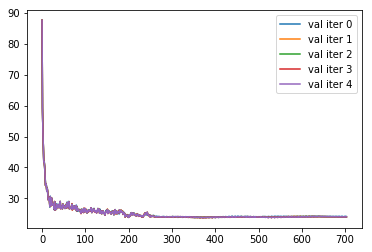

In [15]:
utils.plot_error_on_iterations(history_1, [None, None], [0, 1, 2, 3, 4])

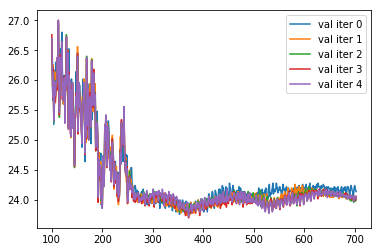

In [16]:
utils.plot_error_on_iterations(history_1, [100, None], [0, 1, 2, 3, 4])

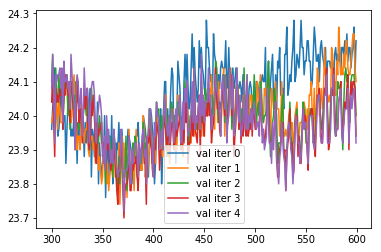

In [17]:
utils.plot_error_on_iterations(history_1, [300, 600], [0, 1, 2, 3, 4])

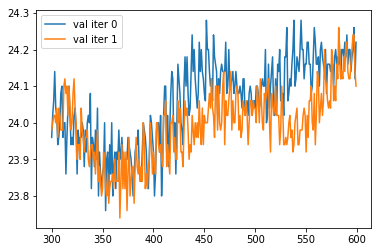

In [18]:
utils.plot_error_on_iterations(history_1, [300, 600], [0, 1])

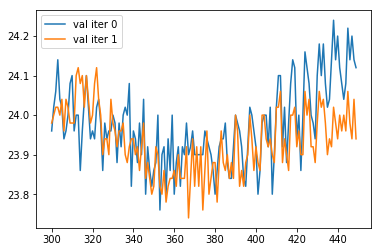

In [19]:
utils.plot_error_on_iterations(history_1, [300, 450], [0, 1])

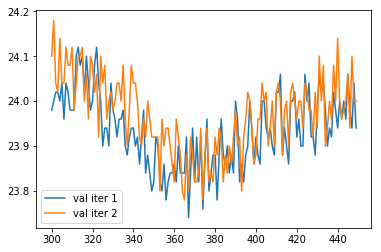

In [20]:
utils.plot_error_on_iterations(history_1, [300, 450], [1, 2])

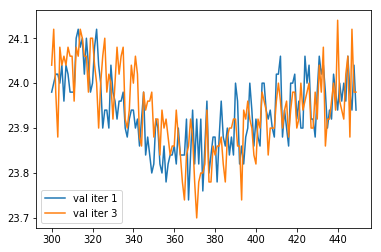

In [21]:
utils.plot_error_on_iterations(history_1, [300, 450], [1, 3])

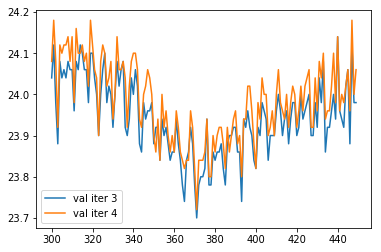

In [22]:
utils.plot_error_on_iterations(history_1, [300, 450], [3, 4])

### Introduced G

In [7]:
def model_step(input_images, prior, batch_size, training, num_labels, use_priors):
    """The Model definition."""
    inputs = input_images
    
    conv1 = tf.layers.conv2d(
        inputs=inputs,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[3, 3], strides=2, padding='same')
    
    norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')

    conv2 = tf.layers.conv2d(
        inputs=norm1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    
    norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')
    
    pool2 = tf.layers.max_pooling2d(inputs=norm2, pool_size=[2, 2], strides=2, padding='same')
    
    pool2_shape = pool2.get_shape()
    num_units_after_conv = pool2_shape[1] * pool2_shape[2] * pool2_shape[3]

    pool2_flat = tf.reshape(pool2, [-1, num_units_after_conv])
    
    if use_priors:
        projections = tf.layers.dense(inputs=prior, units=100, activation=tf.nn.relu)
        gates = tf.layers.dense(inputs=projections, units=num_units_after_conv, activation=tf.nn.sigmoid)
        bias = tf.layers.dense(inputs=projections, units=num_units_after_conv, activation=None)
        
        gated = tf.multiply(pool2_flat, gates) + bias
    else:
        gated = pool2_flat
    
    
    dense1 = tf.layers.dense(inputs=gated, units=384, activation=tf.nn.relu,
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(0.004))
    
    dense2 = tf.layers.dense(inputs=dense1, units=192, activation=tf.nn.relu,
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(0.004))

    logits = tf.layers.dense(inputs=dense2, units=num_labels)
    posteriors = tf.nn.softmax(logits)
    
    return logits, posteriors


def apply(input_images, training, train_labels_node, num_labels, use_priors):
    results = []
    loss = 0.0

    batch_size = input_images.get_shape()[0]
    priors = tf.ones((batch_size, num_labels)) / num_labels
    for step in range(NUM_UNROLL_STEPS):
        with tf.variable_scope('one_step', reuse=(step > 0)):
            logits, posteriors = model_step(input_images, priors, batch_size,
                                            training=training, num_labels=num_labels,
                                            use_priors=use_priors)
        priors = posteriors
        results.append((logits, posteriors))
        loss += tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(labels=train_labels_node, logits=logits))
    return tf.stack([logits for (logits, _) in results]), loss

In [8]:
use_priors = True

tf.reset_default_graph()

dataset = utils.get_dataset(DATASET)

# Optimizer: set up a variable that's incremented once per batch and
# controls the learning rate decay.
batch = tf.Variable(0, dtype=tf.float32)
# Decay once per epoch, using an exponential schedule starting at 0.01.
learning_rate = tf.train.exponential_decay(
    1e-3,                # Base learning rate.
    batch * BATCH_SIZE,  # Current index into the dataset.
    dataset.train_size,          # Decay step.
    0.95,                # Decay rate.
    staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate)

train_config = dict(
    optimizer=optimizer,
    batch_var=batch,
    learning_rate_var=learning_rate,
    train_batch_size=BATCH_SIZE,
    eval_batch_size=EVAL_BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    eval_frequency=EVAL_FREQUENCY,
)

history_2, stdout_lines = utils.run_train(apply, train_config, dataset,
                                          build_func_kwargs=dict(use_priors=use_priors))

Initialized!
Step 0 (epoch 0.00), 14.1 ms
Minibatch loss: 11.116, learning rate: 0.001000
Minibatch error: [73.4375, 73.4375, 73.4375, 73.4375, 73.4375]
Validation error: [84.72, 84.84, 84.84, 84.84, 84.84]
Step 100 (epoch 0.14), 131.8 ms
Minibatch loss: 8.132, learning rate: 0.001000
Minibatch error: [60.9375, 62.5, 62.5, 62.5, 62.5]
Validation error: [56.36, 56.76, 56.72, 56.72, 56.68]
Step 200 (epoch 0.28), 132.0 ms
Minibatch loss: 6.677, learning rate: 0.001000
Minibatch error: [51.5625, 50.0, 50.0, 50.0, 50.0]
Validation error: [52.32, 52.54, 52.54, 52.5, 52.48]
Step 300 (epoch 0.43), 132.0 ms
Minibatch loss: 6.040, learning rate: 0.001000
Minibatch error: [42.1875, 42.1875, 42.1875, 42.1875, 42.1875]
Validation error: [45.8, 45.16, 45.46, 45.36, 45.42]
Step 400 (epoch 0.57), 131.9 ms
Minibatch loss: 6.202, learning rate: 0.001000
Minibatch error: [42.1875, 43.75, 43.75, 43.75, 43.75]
Validation error: [42.58, 41.88, 42.08, 41.98, 42.02]
Step 500 (epoch 0.71), 131.9 ms
Minibatch l

Step 3700 (epoch 5.26), 132.2 ms
Minibatch loss: 0.388, learning rate: 0.000774
Minibatch error: [1.5625, 1.5625, 1.5625, 1.5625, 1.5625]
Validation error: [27.239999999999995, 27.040000000000006, 27.060000000000002, 27.08, 27.08]
Step 3800 (epoch 5.40), 132.3 ms
Minibatch loss: 0.419, learning rate: 0.000774
Minibatch error: [1.5625, 1.5625, 1.5625, 1.5625, 1.5625]
Validation error: [28.14, 28.099999999999994, 28.08, 28.060000000000002, 28.060000000000002]
Step 3900 (epoch 5.55), 132.5 ms
Minibatch loss: 0.228, learning rate: 0.000774
Minibatch error: [1.5625, 1.5625, 1.5625, 1.5625, 1.5625]
Validation error: [26.819999999999993, 27.040000000000006, 27.0, 27.019999999999996, 27.019999999999996]
Step 4000 (epoch 5.69), 132.1 ms
Minibatch loss: 0.687, learning rate: 0.000774
Minibatch error: [4.6875, 4.6875, 4.6875, 4.6875, 4.6875]
Validation error: [31.14, 31.159999999999997, 31.159999999999997, 31.180000000000007, 31.159999999999997]
Step 4100 (epoch 5.83), 132.2 ms
Minibatch loss: 0.

Step 7400 (epoch 10.52), 132.2 ms
Minibatch loss: 0.024, learning rate: 0.000599
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [27.36, 27.28, 27.28, 27.319999999999993, 27.299999999999997]
Step 7500 (epoch 10.67), 132.2 ms
Minibatch loss: 0.013, learning rate: 0.000599
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.700000000000003, 26.700000000000003, 26.78, 26.819999999999993, 26.799999999999997]
Step 7600 (epoch 10.81), 132.3 ms
Minibatch loss: 0.068, learning rate: 0.000599
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.840000000000003, 27.0, 27.019999999999996, 27.060000000000002, 27.040000000000006]
Step 7700 (epoch 10.95), 132.3 ms
Minibatch loss: 0.117, learning rate: 0.000599
Minibatch error: [1.5625, 1.5625, 1.5625, 1.5625, 1.5625]
Validation error: [27.680000000000007, 27.739999999999995, 27.680000000000007, 27.680000000000007, 27.680000000000007]
Step 7800 (epoch 11.09), 132.1 ms
Minibatch loss: 0.064, learning rate: 0.00056

Step 11100 (epoch 15.79), 132.4 ms
Minibatch loss: 0.008, learning rate: 0.000463
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.040000000000006, 25.92, 25.959999999999994, 26.0, 25.959999999999994]
Step 11200 (epoch 15.93), 132.2 ms
Minibatch loss: 0.034, learning rate: 0.000463
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.0, 26.08, 26.060000000000002, 26.060000000000002, 26.060000000000002]
Step 11300 (epoch 16.07), 132.2 ms
Minibatch loss: 0.013, learning rate: 0.000440
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.819999999999993, 26.739999999999995, 26.760000000000005, 26.78, 26.78]
Step 11400 (epoch 16.21), 132.1 ms
Minibatch loss: 0.026, learning rate: 0.000440
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.120000000000005, 26.180000000000007, 26.180000000000007, 26.180000000000007, 26.180000000000007]
Step 11500 (epoch 16.36), 132.3 ms
Minibatch loss: 0.019, learning rate: 0.000440
Minibatch error: [0.0,

Step 14800 (epoch 21.05), 132.3 ms
Minibatch loss: 0.004, learning rate: 0.000341
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.260000000000005, 25.340000000000003, 25.319999999999993, 25.340000000000003, 25.340000000000003]
Step 14900 (epoch 21.19), 132.3 ms
Minibatch loss: 0.011, learning rate: 0.000341
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.5, 25.599999999999994, 25.540000000000006, 25.540000000000006, 25.540000000000006]
Step 15000 (epoch 21.33), 132.4 ms
Minibatch loss: 0.010, learning rate: 0.000341
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.840000000000003, 24.78, 24.819999999999993, 24.819999999999993, 24.819999999999993]
Step 15100 (epoch 21.48), 132.4 ms
Minibatch loss: 0.000, learning rate: 0.000341
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.340000000000003, 25.299999999999997, 25.36, 25.36, 25.36]
Step 15200 (epoch 21.62), 132.3 ms
Minibatch loss: 0.006, learning rate: 0.000341
Minibatc

Step 18500 (epoch 26.31), 132.3 ms
Minibatch loss: 0.010, learning rate: 0.000264
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.659999999999997, 25.72, 25.760000000000005, 25.739999999999995, 25.78]
Step 18600 (epoch 26.45), 132.2 ms
Minibatch loss: 0.003, learning rate: 0.000264
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.040000000000006, 24.959999999999994, 24.980000000000004, 24.980000000000004, 24.959999999999994]
Step 18700 (epoch 26.60), 132.3 ms
Minibatch loss: 0.003, learning rate: 0.000264
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.659999999999997, 24.700000000000003, 24.680000000000007, 24.680000000000007, 24.680000000000007]
Step 18800 (epoch 26.74), 132.6 ms
Minibatch loss: 0.000, learning rate: 0.000264
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.36, 25.5, 25.560000000000002, 25.599999999999994, 25.599999999999994]
Step 18900 (epoch 26.88), 132.2 ms
Minibatch loss: 0.004, learning rate: 0.00

Step 22100 (epoch 31.43), 132.2 ms
Minibatch loss: 0.004, learning rate: 0.000204
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.120000000000005, 25.060000000000002, 25.019999999999996, 25.0, 25.019999999999996]
Step 22200 (epoch 31.57), 132.3 ms
Minibatch loss: 0.004, learning rate: 0.000204
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.099999999999994, 25.14, 25.239999999999995, 25.239999999999995, 25.239999999999995]
Step 22300 (epoch 31.72), 132.2 ms
Minibatch loss: 0.001, learning rate: 0.000204
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.239999999999995, 25.040000000000006, 25.040000000000006, 25.040000000000006, 25.040000000000006]
Step 22400 (epoch 31.86), 132.3 ms
Minibatch loss: 0.004, learning rate: 0.000204
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.22, 25.060000000000002, 25.08, 25.14, 25.14]
Step 22500 (epoch 32.00), 132.4 ms
Minibatch loss: 0.001, learning rate: 0.000194
Minibatch error: [0.0

Step 25800 (epoch 36.69), 132.3 ms
Minibatch loss: 0.001, learning rate: 0.000158
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.879999999999995, 24.959999999999994, 24.92, 24.939999999999998, 24.92]
Step 25900 (epoch 36.84), 132.3 ms
Minibatch loss: 0.000, learning rate: 0.000158
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.0, 25.019999999999996, 24.939999999999998, 24.939999999999998, 24.939999999999998]
Step 26000 (epoch 36.98), 132.0 ms
Minibatch loss: 0.000, learning rate: 0.000158
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.980000000000004, 25.0, 24.900000000000006, 24.900000000000006, 24.900000000000006]
Step 26100 (epoch 37.12), 132.2 ms
Minibatch loss: 0.000, learning rate: 0.000150
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.879999999999995, 24.92, 24.799999999999997, 24.819999999999993, 24.819999999999993]
Step 26200 (epoch 37.26), 132.3 ms
Minibatch loss: 0.002, learning rate: 0.000150
Minibatch

Step 29500 (epoch 41.96), 132.2 ms
Minibatch loss: 0.000, learning rate: 0.000122
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.879999999999995, 24.72, 24.739999999999995, 24.700000000000003, 24.72]
Step 29600 (epoch 42.10), 132.2 ms
Minibatch loss: 0.000, learning rate: 0.000116
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.879999999999995, 24.700000000000003, 24.700000000000003, 24.739999999999995, 24.739999999999995]
Step 29700 (epoch 42.24), 132.4 ms
Minibatch loss: 0.000, learning rate: 0.000116
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.840000000000003, 24.739999999999995, 24.700000000000003, 24.72, 24.72]
Step 29800 (epoch 42.38), 132.3 ms
Minibatch loss: 0.000, learning rate: 0.000116
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.78, 24.739999999999995, 24.659999999999997, 24.659999999999997, 24.659999999999997]
Step 29900 (epoch 42.52), 132.4 ms
Minibatch loss: 0.000, learning rate: 0.000116
Minibat

Step 33200 (epoch 47.22), 132.2 ms
Minibatch loss: 0.000, learning rate: 0.000090
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.680000000000007, 24.540000000000006, 24.540000000000006, 24.58, 24.58]
Step 33300 (epoch 47.36), 132.4 ms
Minibatch loss: 0.000, learning rate: 0.000090
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.659999999999997, 24.620000000000005, 24.58, 24.58, 24.58]
Step 33400 (epoch 47.50), 132.2 ms
Minibatch loss: 0.000, learning rate: 0.000090
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.599999999999994, 24.700000000000003, 24.72, 24.680000000000007, 24.659999999999997]
Step 33500 (epoch 47.64), 132.2 ms
Minibatch loss: 0.000, learning rate: 0.000090
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.659999999999997, 24.659999999999997, 24.680000000000007, 24.659999999999997, 24.659999999999997]
Step 33600 (epoch 47.79), 132.2 ms
Minibatch loss: 0.000, learning rate: 0.000090
Minibatch error: [0.

Step 36900 (epoch 52.48), 132.3 ms
Minibatch loss: 0.000, learning rate: 0.000069
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.58, 24.42, 24.459999999999994, 24.480000000000004, 24.5]
Step 37000 (epoch 52.62), 132.2 ms
Minibatch loss: 0.000, learning rate: 0.000069
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.560000000000002, 24.459999999999994, 24.480000000000004, 24.5, 24.5]
Step 37100 (epoch 52.76), 132.3 ms
Minibatch loss: 0.000, learning rate: 0.000069
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.540000000000006, 24.459999999999994, 24.459999999999994, 24.459999999999994, 24.459999999999994]
Step 37200 (epoch 52.91), 132.4 ms
Minibatch loss: 0.000, learning rate: 0.000069
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.58, 24.459999999999994, 24.42, 24.439999999999998, 24.459999999999994]
Step 37300 (epoch 53.05), 132.4 ms
Minibatch loss: 0.000, learning rate: 0.000066
Minibatch error: [0.0, 0.0, 0.0, 0.0

Step 40500 (epoch 57.60), 132.2 ms
Minibatch loss: 0.000, learning rate: 0.000054
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.319999999999993, 24.340000000000003, 24.36, 24.379999999999995, 24.36]
Step 40600 (epoch 57.74), 132.2 ms
Minibatch loss: 0.000, learning rate: 0.000054
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.340000000000003, 24.299999999999997, 24.28, 24.28, 24.260000000000005]
Step 40700 (epoch 57.88), 132.0 ms
Minibatch loss: 0.000, learning rate: 0.000054
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.36, 24.319999999999993, 24.260000000000005, 24.22, 24.22]
Step 40800 (epoch 58.03), 132.3 ms
Minibatch loss: 0.000, learning rate: 0.000051
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.28, 24.28, 24.22, 24.239999999999995, 24.260000000000005]
Step 40900 (epoch 58.17), 132.0 ms
Minibatch loss: 0.000, learning rate: 0.000051
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.2999999

Step 44200 (epoch 62.86), 132.6 ms
Minibatch loss: 0.000, learning rate: 0.000042
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.319999999999993, 24.159999999999997, 24.120000000000005, 24.120000000000005, 24.159999999999997]
Step 44300 (epoch 63.00), 132.4 ms
Minibatch loss: 0.000, learning rate: 0.000039
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.28, 24.22, 24.200000000000003, 24.180000000000007, 24.200000000000003]
Step 44400 (epoch 63.15), 132.3 ms
Minibatch loss: 0.000, learning rate: 0.000039
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.299999999999997, 24.14, 24.159999999999997, 24.14, 24.120000000000005]
Step 44500 (epoch 63.29), 132.4 ms
Minibatch loss: 0.000, learning rate: 0.000039
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.36, 24.200000000000003, 24.22, 24.200000000000003, 24.159999999999997]
Step 44600 (epoch 63.43), 132.4 ms
Minibatch loss: 0.000, learning rate: 0.000039
Minibatch error: [0.

Step 47900 (epoch 68.12), 132.2 ms
Minibatch loss: 0.000, learning rate: 0.000031
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.159999999999997, 24.040000000000006, 24.019999999999996, 24.0, 24.0]
Step 48000 (epoch 68.27), 132.0 ms
Minibatch loss: 0.000, learning rate: 0.000031
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.299999999999997, 24.159999999999997, 24.08, 24.099999999999994, 24.08]
Step 48100 (epoch 68.41), 132.3 ms
Minibatch loss: 0.000, learning rate: 0.000031
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.239999999999995, 24.060000000000002, 24.0, 24.040000000000006, 24.060000000000002]
Step 48200 (epoch 68.55), 132.1 ms
Minibatch loss: 0.000, learning rate: 0.000031
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.14, 24.099999999999994, 24.040000000000006, 24.08, 24.08]
Step 48300 (epoch 68.69), 132.6 ms
Minibatch loss: 0.000, learning rate: 0.000031
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Valida

Step 51600 (epoch 73.39), 132.2 ms
Minibatch loss: 0.000, learning rate: 0.000024
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.260000000000005, 24.180000000000007, 24.14, 24.120000000000005, 24.099999999999994]
Step 51700 (epoch 73.53), 132.3 ms
Minibatch loss: 0.000, learning rate: 0.000024
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.159999999999997, 24.200000000000003, 24.180000000000007, 24.239999999999995, 24.22]
Step 51800 (epoch 73.67), 132.4 ms
Minibatch loss: 0.000, learning rate: 0.000024
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.180000000000007, 24.159999999999997, 24.14, 24.14, 24.14]
Step 51900 (epoch 73.81), 132.6 ms
Minibatch loss: 0.000, learning rate: 0.000024
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.159999999999997, 24.120000000000005, 24.14, 24.120000000000005, 24.159999999999997]
Step 52000 (epoch 73.96), 132.2 ms
Minibatch loss: 0.000, learning rate: 0.000024
Minibatch error: [0.

Step 55300 (epoch 78.65), 132.2 ms
Minibatch loss: 0.000, learning rate: 0.000018
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.14, 24.22, 24.299999999999997, 24.299999999999997, 24.28]
Step 55400 (epoch 78.79), 132.3 ms
Minibatch loss: 0.000, learning rate: 0.000018
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.260000000000005, 24.22, 24.200000000000003, 24.239999999999995, 24.28]
Step 55500 (epoch 78.93), 132.3 ms
Minibatch loss: 0.000, learning rate: 0.000018
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.260000000000005, 24.22, 24.200000000000003, 24.239999999999995, 24.239999999999995]
Step 55600 (epoch 79.08), 132.3 ms
Minibatch loss: 0.000, learning rate: 0.000017
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.299999999999997, 24.260000000000005, 24.22, 24.180000000000007, 24.159999999999997]
Step 55700 (epoch 79.22), 132.2 ms
Minibatch loss: 0.000, learning rate: 0.000017
Minibatch error: [0.0, 0.0, 0.0, 

Step 58900 (epoch 83.77), 132.2 ms
Minibatch loss: 0.000, learning rate: 0.000014
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.22, 24.239999999999995, 24.28, 24.260000000000005, 24.260000000000005]
Step 59000 (epoch 83.91), 132.0 ms
Minibatch loss: 0.000, learning rate: 0.000014
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.239999999999995, 24.260000000000005, 24.319999999999993, 24.260000000000005, 24.260000000000005]
Step 59100 (epoch 84.05), 132.0 ms
Minibatch loss: 0.000, learning rate: 0.000013
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.319999999999993, 24.159999999999997, 24.22, 24.200000000000003, 24.239999999999995]
Step 59200 (epoch 84.20), 132.0 ms
Minibatch loss: 0.000, learning rate: 0.000013
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.28, 24.200000000000003, 24.159999999999997, 24.180000000000007, 24.14]
Step 59300 (epoch 84.34), 131.9 ms
Minibatch loss: 0.000, learning rate: 0.000013
Minibat

Step 62600 (epoch 89.03), 131.9 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.299999999999997, 24.28, 24.28, 24.28, 24.299999999999997]
Step 62700 (epoch 89.17), 131.8 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.180000000000007, 24.200000000000003, 24.28, 24.319999999999993, 24.319999999999993]
Step 62800 (epoch 89.32), 132.0 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.22, 24.239999999999995, 24.299999999999997, 24.299999999999997, 24.28]
Step 62900 (epoch 89.46), 131.7 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.260000000000005, 24.319999999999993, 24.340000000000003, 24.340000000000003, 24.319999999999993]
Step 63000 (epoch 89.60), 131.8 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch error: [0.

Step 66300 (epoch 94.29), 132.0 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.180000000000007, 24.22, 24.28, 24.28, 24.299999999999997]
Step 66400 (epoch 94.44), 132.1 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.22, 24.260000000000005, 24.299999999999997, 24.319999999999993, 24.299999999999997]
Step 66500 (epoch 94.58), 132.2 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.22, 24.239999999999995, 24.28, 24.260000000000005, 24.260000000000005]
Step 66600 (epoch 94.72), 132.0 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.200000000000003, 24.22, 24.239999999999995, 24.239999999999995, 24.22]
Step 66700 (epoch 94.86), 132.3 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Val

Step 70000 (epoch 99.56), 132.0 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.200000000000003, 24.239999999999995, 24.319999999999993, 24.299999999999997, 24.28]
Step 70100 (epoch 99.70), 132.3 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.22, 24.22, 24.239999999999995, 24.260000000000005, 24.299999999999997]
Step 70200 (epoch 99.84), 131.9 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.200000000000003, 24.22, 24.28, 24.28, 24.28]
Step 70300 (epoch 99.98), 132.1 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.22, 24.260000000000005, 24.28, 24.299999999999997, 24.299999999999997]
Test error: [25.620000000000005, 25.629999999999995, 25.680000000000007, 25.680000000000007, 25.689999999999998]


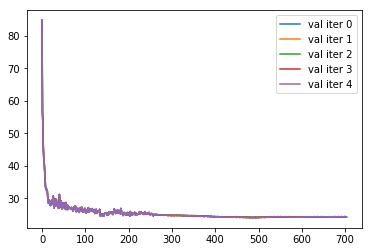

In [23]:
utils.plot_error_on_iterations(history_2, [None, None], [0, 1, 2, 3, 4])

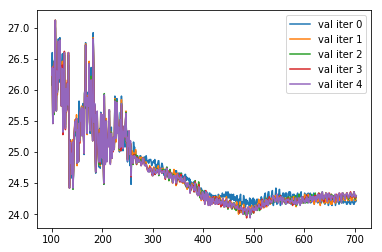

In [24]:
utils.plot_error_on_iterations(history_2, [100, None], [0, 1, 2, 3, 4])

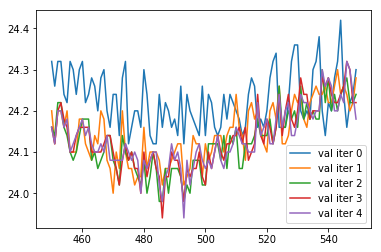

In [25]:
utils.plot_error_on_iterations(history_2, [450, 550], [0, 1, 2, 3, 4])

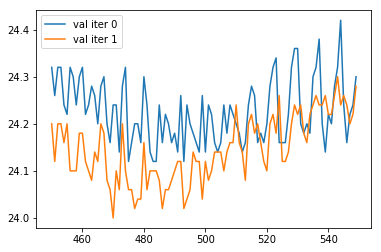

In [26]:
utils.plot_error_on_iterations(history_2, [450, 550], [0, 1])

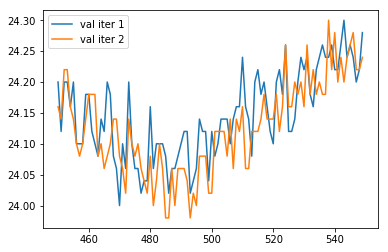

In [27]:
utils.plot_error_on_iterations(history_2, [450, 550], [1, 2])

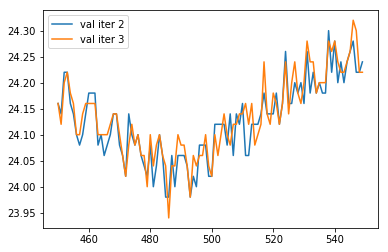

In [28]:
utils.plot_error_on_iterations(history_2, [450, 550], [2, 3])

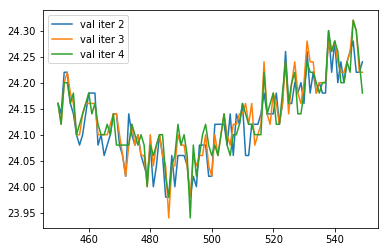

In [29]:
utils.plot_error_on_iterations(history_2, [450, 550], [2, 3, 4])

## Separate 2-layer networks for F and G

In [13]:
def model_step(input_images, prior, batch_size, training, num_labels, use_priors):
    """The Model definition."""
    inputs = input_images
    
    conv1 = tf.layers.conv2d(
        inputs=inputs,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[3, 3], strides=2, padding='same')
    
    norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')

    conv2 = tf.layers.conv2d(
        inputs=norm1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    
    norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')
    
    pool2 = tf.layers.max_pooling2d(inputs=norm2, pool_size=[2, 2], strides=2, padding='same')
    
    pool2_shape = pool2.get_shape()
    num_units_after_conv = pool2_shape[1] * pool2_shape[2] * pool2_shape[3]

    pool2_flat = tf.reshape(pool2, [-1, num_units_after_conv])
    
    if use_priors:
        projections_for_gates = tf.layers.dense(inputs=prior, units=100, activation=tf.nn.relu)
        gates = tf.layers.dense(inputs=projections_for_gates, units=num_units_after_conv, activation=tf.nn.sigmoid)
        projections_for_bias = tf.layers.dense(inputs=prior, units=100, activation=tf.nn.relu)
        bias = tf.layers.dense(inputs=projections_for_bias, units=num_units_after_conv, activation=None)
        
        gated = tf.multiply(pool2_flat, gates) + bias
    else:
        gated = pool2_flat
    
    
    dense1 = tf.layers.dense(inputs=gated, units=384, activation=tf.nn.relu,
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(0.004))
    
    dense2 = tf.layers.dense(inputs=dense1, units=192, activation=tf.nn.relu,
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(0.004))

    logits = tf.layers.dense(inputs=dense2, units=num_labels)
    posteriors = tf.nn.softmax(logits)
    
    return logits, posteriors



def apply(input_images, training, train_labels_node, num_labels, use_priors):
    results = []
    loss = 0.0

    batch_size = input_images.get_shape()[0]
    priors = tf.ones((batch_size, num_labels)) / num_labels
    for step in range(NUM_UNROLL_STEPS):
        with tf.variable_scope('one_step', reuse=(step > 0)):
            logits, posteriors = model_step(input_images, priors, batch_size,
                                            training=training, num_labels=num_labels,
                                            use_priors=use_priors)
        priors = posteriors
        results.append((logits, posteriors))
        loss += tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(labels=train_labels_node, logits=logits))
    return tf.stack([logits for (logits, _) in results]), loss

In [14]:
use_priors = True

tf.reset_default_graph()

dataset = utils.get_dataset(DATASET)

# Optimizer: set up a variable that's incremented once per batch and
# controls the learning rate decay.
batch = tf.Variable(0, dtype=tf.float32)
# Decay once per epoch, using an exponential schedule starting at 0.01.
learning_rate = tf.train.exponential_decay(
    1e-3,                # Base learning rate.
    batch * BATCH_SIZE,  # Current index into the dataset.
    dataset.train_size,          # Decay step.
    0.95,                # Decay rate.
    staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate)

train_config = dict(
    optimizer=optimizer,
    batch_var=batch,
    learning_rate_var=learning_rate,
    train_batch_size=BATCH_SIZE,
    eval_batch_size=EVAL_BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    eval_frequency=EVAL_FREQUENCY,
)

history_4, stdout_lines = utils.run_train(apply, train_config, dataset,
                                        build_func_kwargs=dict(use_priors=use_priors))

Initialized!
Step 0 (epoch 0.00), 14.2 ms
Minibatch loss: 10.987, learning rate: 0.001000
Minibatch error: [70.3125, 70.3125, 70.3125, 70.3125, 70.3125]
Validation error: [85.78, 86.0, 86.0, 86.0, 86.0]
Step 100 (epoch 0.14), 133.5 ms
Minibatch loss: 8.111, learning rate: 0.001000
Minibatch error: [51.5625, 53.125, 53.125, 53.125, 53.125]
Validation error: [58.5, 58.96, 59.02, 58.98, 58.98]
Step 200 (epoch 0.28), 133.4 ms
Minibatch loss: 6.897, learning rate: 0.001000
Minibatch error: [43.75, 51.5625, 46.875, 50.0, 50.0]
Validation error: [49.84, 51.32, 50.98, 51.0, 50.98]
Step 300 (epoch 0.43), 133.2 ms
Minibatch loss: 6.258, learning rate: 0.001000
Minibatch error: [53.125, 54.6875, 56.25, 56.25, 56.25]
Validation error: [45.76, 46.08, 45.98, 46.08, 46.02]
Step 400 (epoch 0.57), 133.3 ms
Minibatch loss: 6.014, learning rate: 0.001000
Minibatch error: [42.1875, 42.1875, 40.625, 40.625, 40.625]
Validation error: [43.28, 43.74, 43.58, 43.7, 43.64]
Step 500 (epoch 0.71), 133.6 ms
Minibat

Step 3700 (epoch 5.26), 133.6 ms
Minibatch loss: 0.313, learning rate: 0.000774
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [29.040000000000006, 29.040000000000006, 29.019999999999996, 29.019999999999996, 29.0]
Step 3800 (epoch 5.40), 133.4 ms
Minibatch loss: 0.351, learning rate: 0.000774
Minibatch error: [1.5625, 0.0, 0.0, 0.0, 0.0]
Validation error: [29.0, 28.86, 28.879999999999995, 28.86, 28.819999999999993]
Step 3900 (epoch 5.55), 133.7 ms
Minibatch loss: 0.202, learning rate: 0.000774
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [27.439999999999998, 27.42, 27.439999999999998, 27.439999999999998, 27.5]
Step 4000 (epoch 5.69), 133.5 ms
Minibatch loss: 0.159, learning rate: 0.000774
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [30.599999999999994, 30.86, 30.900000000000006, 30.819999999999993, 30.819999999999993]
Step 4100 (epoch 5.83), 133.8 ms
Minibatch loss: 0.479, learning rate: 0.000774
Minibatch error: [1.5625, 1.5625, 1.5625, 1

Step 8300 (epoch 11.80), 133.5 ms
Minibatch loss: 0.040, learning rate: 0.000569
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.700000000000003, 26.400000000000006, 26.459999999999994, 26.42, 26.42]
Step 8400 (epoch 11.95), 133.4 ms
Minibatch loss: 0.014, learning rate: 0.000569
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [27.519999999999996, 27.459999999999994, 27.36, 27.340000000000003, 27.319999999999993]
Step 8500 (epoch 12.09), 133.7 ms
Minibatch loss: 0.058, learning rate: 0.000540
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [27.58, 27.480000000000004, 27.659999999999997, 27.519999999999996, 27.659999999999997]
Step 8600 (epoch 12.23), 133.6 ms
Minibatch loss: 0.063, learning rate: 0.000540
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [27.239999999999995, 27.64, 27.5, 27.58, 27.519999999999996]
Step 8700 (epoch 12.37), 133.6 ms
Minibatch loss: 0.021, learning rate: 0.000540
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0

Step 12000 (epoch 17.07), 133.9 ms
Minibatch loss: 0.011, learning rate: 0.000418
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [27.5, 27.200000000000003, 27.28, 27.239999999999995, 27.180000000000007]
Step 12100 (epoch 17.21), 133.7 ms
Minibatch loss: 0.003, learning rate: 0.000418
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.700000000000003, 26.599999999999994, 26.680000000000007, 26.620000000000005, 26.659999999999997]
Step 12200 (epoch 17.35), 134.2 ms
Minibatch loss: 0.005, learning rate: 0.000418
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.72, 26.620000000000005, 26.620000000000005, 26.64, 26.599999999999994]
Step 12300 (epoch 17.49), 134.1 ms
Minibatch loss: 0.009, learning rate: 0.000418
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.78, 26.659999999999997, 26.560000000000002, 26.58, 26.519999999999996]
Step 12400 (epoch 17.64), 134.2 ms
Minibatch loss: 0.004, learning rate: 0.000418
Minibatch error: [0.0

Step 15600 (epoch 22.19), 133.6 ms
Minibatch loss: 0.003, learning rate: 0.000324
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.879999999999995, 25.680000000000007, 25.680000000000007, 25.700000000000003, 25.680000000000007]
Step 15700 (epoch 22.33), 133.8 ms
Minibatch loss: 0.011, learning rate: 0.000324
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.299999999999997, 26.22, 26.019999999999996, 26.099999999999994, 26.019999999999996]
Step 15800 (epoch 22.47), 133.7 ms
Minibatch loss: 0.002, learning rate: 0.000324
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.879999999999995, 25.459999999999994, 25.519999999999996, 25.540000000000006, 25.540000000000006]
Step 15900 (epoch 22.61), 133.8 ms
Minibatch loss: 0.024, learning rate: 0.000324
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.480000000000004, 26.239999999999995, 26.239999999999995, 26.22, 26.22]
Step 16000 (epoch 22.76), 133.6 ms
Minibatch loss: 0.020, learn

Step 19300 (epoch 27.45), 133.8 ms
Minibatch loss: 0.007, learning rate: 0.000250
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.260000000000005, 26.260000000000005, 26.159999999999997, 26.22, 26.159999999999997]
Step 19400 (epoch 27.59), 133.7 ms
Minibatch loss: 0.003, learning rate: 0.000250
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.799999999999997, 25.620000000000005, 25.700000000000003, 25.659999999999997, 25.599999999999994]
Step 19500 (epoch 27.73), 133.7 ms
Minibatch loss: 0.002, learning rate: 0.000250
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.64, 26.540000000000006, 26.519999999999996, 26.5, 26.5]
Step 19600 (epoch 27.88), 133.6 ms
Minibatch loss: 0.001, learning rate: 0.000250
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.319999999999993, 26.180000000000007, 26.22, 26.180000000000007, 26.239999999999995]
Step 19700 (epoch 28.02), 133.7 ms
Minibatch loss: 0.000, learning rate: 0.000238
Minibatch

Step 23000 (epoch 32.71), 134.1 ms
Minibatch loss: 0.000, learning rate: 0.000194
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.879999999999995, 25.519999999999996, 25.439999999999998, 25.439999999999998, 25.439999999999998]
Step 23100 (epoch 32.85), 133.8 ms
Minibatch loss: 0.000, learning rate: 0.000194
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.799999999999997, 25.560000000000002, 25.400000000000006, 25.42, 25.400000000000006]
Step 23200 (epoch 33.00), 134.2 ms
Minibatch loss: 0.000, learning rate: 0.000194
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.900000000000006, 25.58, 25.459999999999994, 25.439999999999998, 25.42]
Step 23300 (epoch 33.14), 134.1 ms
Minibatch loss: 0.000, learning rate: 0.000184
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.980000000000004, 25.64, 25.560000000000002, 25.560000000000002, 25.519999999999996]
Step 23400 (epoch 33.28), 134.2 ms
Minibatch loss: 0.000, learning rate: 0.0

Step 26700 (epoch 37.97), 133.7 ms
Minibatch loss: 0.000, learning rate: 0.000150
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.819999999999993, 25.540000000000006, 25.540000000000006, 25.519999999999996, 25.459999999999994]
Step 26800 (epoch 38.12), 133.5 ms
Minibatch loss: 0.000, learning rate: 0.000142
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.78, 25.540000000000006, 25.58, 25.519999999999996, 25.540000000000006]
Step 26900 (epoch 38.26), 133.7 ms
Minibatch loss: 0.000, learning rate: 0.000142
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.739999999999995, 25.540000000000006, 25.5, 25.459999999999994, 25.439999999999998]
Step 27000 (epoch 38.40), 133.8 ms
Minibatch loss: 0.000, learning rate: 0.000142
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.840000000000003, 25.480000000000004, 25.42, 25.439999999999998, 25.400000000000006]
Step 27100 (epoch 38.54), 133.7 ms
Minibatch loss: 0.000, learning rate: 0.00

Step 30400 (epoch 43.24), 133.6 ms
Minibatch loss: 0.000, learning rate: 0.000110
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.439999999999998, 25.36, 25.239999999999995, 25.260000000000005, 25.260000000000005]
Step 30500 (epoch 43.38), 133.5 ms
Minibatch loss: 0.000, learning rate: 0.000110
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.36, 25.340000000000003, 25.260000000000005, 25.260000000000005, 25.239999999999995]
Step 30600 (epoch 43.52), 133.9 ms
Minibatch loss: 0.000, learning rate: 0.000110
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.340000000000003, 25.340000000000003, 25.239999999999995, 25.22, 25.200000000000003]
Step 30700 (epoch 43.66), 133.5 ms
Minibatch loss: 0.000, learning rate: 0.000110
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.400000000000006, 25.36, 25.28, 25.200000000000003, 25.239999999999995]
Step 30800 (epoch 43.80), 133.6 ms
Minibatch loss: 0.000, learning rate: 0.000110
Minibat

Step 34100 (epoch 48.50), 133.6 ms
Minibatch loss: 0.000, learning rate: 0.000085
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.180000000000007, 25.120000000000005, 25.019999999999996, 24.980000000000004, 24.92]
Step 34200 (epoch 48.64), 133.6 ms
Minibatch loss: 0.000, learning rate: 0.000085
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.159999999999997, 25.099999999999994, 25.019999999999996, 25.040000000000006, 25.060000000000002]
Step 34300 (epoch 48.78), 133.7 ms
Minibatch loss: 0.000, learning rate: 0.000085
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.14, 25.120000000000005, 25.08, 25.019999999999996, 24.939999999999998]
Step 34400 (epoch 48.92), 133.7 ms
Minibatch loss: 0.000, learning rate: 0.000085
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.099999999999994, 25.099999999999994, 25.0, 24.92, 24.900000000000006]
Step 34500 (epoch 49.07), 133.8 ms
Minibatch loss: 0.000, learning rate: 0.000081
Minibatc

Step 37800 (epoch 53.76), 133.6 ms
Minibatch loss: 0.000, learning rate: 0.000066
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.959999999999994, 24.840000000000003, 24.680000000000007, 24.739999999999995, 24.72]
Step 37900 (epoch 53.90), 134.0 ms
Minibatch loss: 0.000, learning rate: 0.000066
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.900000000000006, 24.680000000000007, 24.799999999999997, 24.72, 24.700000000000003]
Step 38000 (epoch 54.04), 133.7 ms
Minibatch loss: 0.000, learning rate: 0.000063
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.900000000000006, 24.680000000000007, 24.700000000000003, 24.680000000000007, 24.72]
Step 38100 (epoch 54.19), 133.8 ms
Minibatch loss: 0.000, learning rate: 0.000063
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.92, 24.700000000000003, 24.64, 24.659999999999997, 24.64]
Step 38200 (epoch 54.33), 134.0 ms
Minibatch loss: 0.000, learning rate: 0.000063
Minibatch error: [0.

Step 41500 (epoch 59.02), 133.8 ms
Minibatch loss: 0.000, learning rate: 0.000048
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.760000000000005, 24.5, 24.42, 24.439999999999998, 24.5]
Step 41600 (epoch 59.16), 133.9 ms
Minibatch loss: 0.000, learning rate: 0.000048
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.78, 24.5, 24.480000000000004, 24.519999999999996, 24.540000000000006]
Step 41700 (epoch 59.31), 133.7 ms
Minibatch loss: 0.000, learning rate: 0.000048
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.78, 24.599999999999994, 24.58, 24.540000000000006, 24.519999999999996]
Step 41800 (epoch 59.45), 133.9 ms
Minibatch loss: 0.000, learning rate: 0.000048
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.819999999999993, 24.64, 24.620000000000005, 24.58, 24.58]
Step 41900 (epoch 59.59), 133.9 ms
Minibatch loss: 0.000, learning rate: 0.000048
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.72, 24.599

Step 45200 (epoch 64.28), 133.8 ms
Minibatch loss: 0.000, learning rate: 0.000038
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.659999999999997, 24.519999999999996, 24.459999999999994, 24.459999999999994, 24.439999999999998]
Step 45300 (epoch 64.43), 134.0 ms
Minibatch loss: 0.000, learning rate: 0.000038
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.72, 24.58, 24.42, 24.400000000000006, 24.36]
Step 45400 (epoch 64.57), 134.0 ms
Minibatch loss: 0.000, learning rate: 0.000038
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.72, 24.540000000000006, 24.439999999999998, 24.400000000000006, 24.379999999999995]
Step 45500 (epoch 64.71), 134.0 ms
Minibatch loss: 0.000, learning rate: 0.000038
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.680000000000007, 24.480000000000004, 24.400000000000006, 24.379999999999995, 24.340000000000003]
Step 45600 (epoch 64.85), 133.9 ms
Minibatch loss: 0.000, learning rate: 0.000038
Minibat

Step 48900 (epoch 69.55), 134.0 ms
Minibatch loss: 0.000, learning rate: 0.000029
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.819999999999993, 24.5, 24.480000000000004, 24.36, 24.36]
Step 49000 (epoch 69.69), 133.7 ms
Minibatch loss: 0.000, learning rate: 0.000029
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.799999999999997, 24.64, 24.480000000000004, 24.459999999999994, 24.459999999999994]
Step 49100 (epoch 69.83), 133.8 ms
Minibatch loss: 0.000, learning rate: 0.000029
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.799999999999997, 24.519999999999996, 24.379999999999995, 24.439999999999998, 24.42]
Step 49200 (epoch 69.97), 133.5 ms
Minibatch loss: 0.000, learning rate: 0.000029
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.78, 24.519999999999996, 24.42, 24.439999999999998, 24.459999999999994]
Step 49300 (epoch 70.12), 133.6 ms
Minibatch loss: 0.000, learning rate: 0.000028
Minibatch error: [0.0, 0.0, 0.0, 0

Step 52600 (epoch 74.81), 133.9 ms
Minibatch loss: 0.000, learning rate: 0.000022
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.840000000000003, 24.620000000000005, 24.5, 24.519999999999996, 24.5]
Step 52700 (epoch 74.95), 133.8 ms
Minibatch loss: 0.000, learning rate: 0.000022
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.680000000000007, 24.540000000000006, 24.459999999999994, 24.519999999999996, 24.519999999999996]
Step 52800 (epoch 75.09), 134.1 ms
Minibatch loss: 0.000, learning rate: 0.000021
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.72, 24.599999999999994, 24.439999999999998, 24.439999999999998, 24.400000000000006]
Step 52900 (epoch 75.24), 134.1 ms
Minibatch loss: 0.000, learning rate: 0.000021
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.72, 24.560000000000002, 24.480000000000004, 24.459999999999994, 24.459999999999994]
Step 53000 (epoch 75.38), 134.0 ms
Minibatch loss: 0.000, learning rate: 0.000

Step 56300 (epoch 80.07), 134.0 ms
Minibatch loss: 0.000, learning rate: 0.000017
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.819999999999993, 24.64, 24.540000000000006, 24.560000000000002, 24.560000000000002]
Step 56400 (epoch 80.21), 133.9 ms
Minibatch loss: 0.000, learning rate: 0.000017
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.78, 24.540000000000006, 24.439999999999998, 24.5, 24.480000000000004]
Step 56500 (epoch 80.36), 133.9 ms
Minibatch loss: 0.000, learning rate: 0.000017
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.819999999999993, 24.620000000000005, 24.5, 24.439999999999998, 24.400000000000006]
Step 56600 (epoch 80.50), 134.1 ms
Minibatch loss: 0.000, learning rate: 0.000017
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.86, 24.599999999999994, 24.5, 24.519999999999996, 24.5]
Step 56700 (epoch 80.64), 133.9 ms
Minibatch loss: 0.000, learning rate: 0.000017
Minibatch error: [0.0, 0.0, 0.0, 0.0,

Step 60000 (epoch 85.33), 133.9 ms
Minibatch loss: 0.000, learning rate: 0.000013
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.840000000000003, 24.599999999999994, 24.540000000000006, 24.540000000000006, 24.540000000000006]
Step 60100 (epoch 85.48), 134.0 ms
Minibatch loss: 0.000, learning rate: 0.000013
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.879999999999995, 24.480000000000004, 24.519999999999996, 24.5, 24.480000000000004]
Step 60200 (epoch 85.62), 134.1 ms
Minibatch loss: 0.000, learning rate: 0.000013
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.92, 24.599999999999994, 24.560000000000002, 24.519999999999996, 24.480000000000004]
Step 60300 (epoch 85.76), 133.8 ms
Minibatch loss: 0.000, learning rate: 0.000013
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.879999999999995, 24.599999999999994, 24.519999999999996, 24.540000000000006, 24.5]
Step 60400 (epoch 85.90), 133.9 ms
Minibatch loss: 0.000, learnin

Step 63700 (epoch 90.60), 134.2 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.86, 24.599999999999994, 24.5, 24.540000000000006, 24.480000000000004]
Step 63800 (epoch 90.74), 134.2 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.879999999999995, 24.64, 24.519999999999996, 24.5, 24.480000000000004]
Step 63900 (epoch 90.88), 134.0 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.840000000000003, 24.620000000000005, 24.519999999999996, 24.540000000000006, 24.5]
Step 64000 (epoch 91.02), 134.0 ms
Minibatch loss: 0.000, learning rate: 0.000009
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.799999999999997, 24.58, 24.540000000000006, 24.560000000000002, 24.519999999999996]
Step 64100 (epoch 91.16), 134.0 ms
Minibatch loss: 0.000, learning rate: 0.000009
Minibatch error: [0.0, 

Step 67400 (epoch 95.86), 133.9 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.760000000000005, 24.599999999999994, 24.540000000000006, 24.560000000000002, 24.519999999999996]
Step 67500 (epoch 96.00), 133.9 ms
Minibatch loss: 0.000, learning rate: 0.000007
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.78, 24.620000000000005, 24.560000000000002, 24.58, 24.540000000000006]
Step 67600 (epoch 96.14), 133.9 ms
Minibatch loss: 0.000, learning rate: 0.000007
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.78, 24.64, 24.599999999999994, 24.560000000000002, 24.560000000000002]
Step 67700 (epoch 96.28), 133.8 ms
Minibatch loss: 0.000, learning rate: 0.000007
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.78, 24.64, 24.58, 24.560000000000002, 24.540000000000006]
Step 67800 (epoch 96.43), 134.2 ms
Minibatch loss: 0.000, learning rate: 0.000007
Minibatch error: [0.0, 0.0, 0.0, 

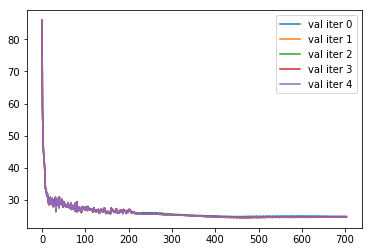

In [30]:
utils.plot_error_on_iterations(history_4, [None, None], [0, 1, 2, 3, 4])

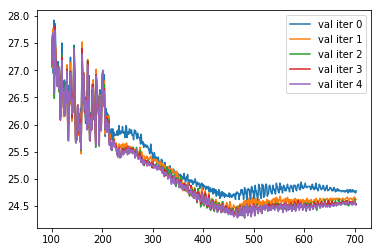

In [31]:
utils.plot_error_on_iterations(history_4, [100, None], [0, 1, 2, 3, 4])

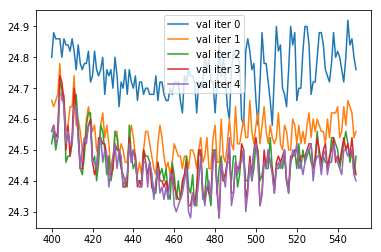

In [32]:
utils.plot_error_on_iterations(history_4, [400, 550], [0, 1, 2, 3, 4])

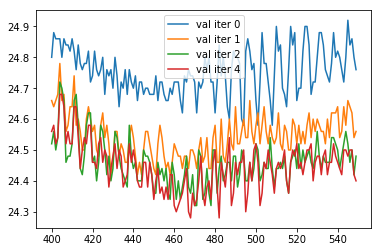

In [33]:
utils.plot_error_on_iterations(history_4, [400, 550], [0, 1, 2, 4])

## Separate 3-layer networks for F and G

In [11]:
def model_step(input_images, prior, batch_size, training, num_labels, use_priors):
    """The Model definition."""
    inputs = input_images
    
    conv1 = tf.layers.conv2d(
        inputs=inputs,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[3, 3], strides=2, padding='same')
    
    norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')

    conv2 = tf.layers.conv2d(
        inputs=norm1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    
    norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')
    
    pool2 = tf.layers.max_pooling2d(inputs=norm2, pool_size=[2, 2], strides=2, padding='same')
    
    pool2_shape = pool2.get_shape()
    num_units_after_conv = pool2_shape[1] * pool2_shape[2] * pool2_shape[3]

    pool2_flat = tf.reshape(pool2, [-1, num_units_after_conv])
    
    if use_priors:
        projections_for_gates = tf.layers.dense(inputs=prior, units=100, activation=tf.nn.relu)
        projections_for_gates = tf.layers.dense(inputs=projections_for_gates, units=100, activation=tf.nn.relu)
        gates = tf.layers.dense(inputs=projections_for_gates, units=num_units_after_conv, activation=tf.nn.sigmoid)
        
        projections_for_bias = tf.layers.dense(inputs=prior, units=100, activation=tf.nn.relu)
        projections_for_bias = tf.layers.dense(inputs=projections_for_bias, units=100, activation=tf.nn.relu)
        bias = tf.layers.dense(inputs=projections_for_bias, units=num_units_after_conv, activation=None)
        
        gated = tf.multiply(pool2_flat, gates) + bias
    else:
        gated = pool2_flat
    
    
    dense1 = tf.layers.dense(inputs=gated, units=384, activation=tf.nn.relu,
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(0.004))
    
    dense2 = tf.layers.dense(inputs=dense1, units=192, activation=tf.nn.relu,
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(0.004))

    logits = tf.layers.dense(inputs=dense2, units=num_labels)
    posteriors = tf.nn.softmax(logits)
    
    return logits, posteriors



def apply(input_images, training, train_labels_node, num_labels, use_priors):
    results = []
    loss = 0.0

    batch_size = input_images.get_shape()[0]
    priors = tf.ones((batch_size, num_labels)) / num_labels
    for step in range(NUM_UNROLL_STEPS):
        with tf.variable_scope('one_step', reuse=(step > 0)):
            logits, posteriors = model_step(input_images, priors, batch_size,
                                            training=training, num_labels=num_labels,
                                            use_priors=use_priors)
        priors = posteriors
        results.append((logits, posteriors))
        loss += tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(labels=train_labels_node, logits=logits))
    return tf.stack([logits for (logits, _) in results]), loss

In [12]:
use_priors = True

tf.reset_default_graph()

dataset = utils.get_dataset(DATASET)

# Optimizer: set up a variable that's incremented once per batch and
# controls the learning rate decay.
batch = tf.Variable(0, dtype=tf.float32)
# Decay once per epoch, using an exponential schedule starting at 0.01.
learning_rate = tf.train.exponential_decay(
    1e-3,                # Base learning rate.
    batch * BATCH_SIZE,  # Current index into the dataset.
    dataset.train_size,          # Decay step.
    0.95,                # Decay rate.
    staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate)

train_config = dict(
    optimizer=optimizer,
    batch_var=batch,
    learning_rate_var=learning_rate,
    train_batch_size=BATCH_SIZE,
    eval_batch_size=EVAL_BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    eval_frequency=EVAL_FREQUENCY,
)

history_3, stdout_lines = utils.run_train(apply, train_config, dataset,
                                        build_func_kwargs=dict(use_priors=use_priors))

Initialized!
Step 0 (epoch 0.00), 15.1 ms
Minibatch loss: 11.131, learning rate: 0.001000
Minibatch error: [71.875, 71.875, 71.875, 71.875, 71.875]
Validation error: [86.48, 86.26, 86.26, 86.26, 86.26]
Step 100 (epoch 0.14), 136.9 ms
Minibatch loss: 7.926, learning rate: 0.001000
Minibatch error: [53.125, 53.125, 53.125, 53.125, 53.125]
Validation error: [55.74, 56.02, 55.96, 55.98, 55.98]
Step 200 (epoch 0.28), 137.0 ms
Minibatch loss: 6.668, learning rate: 0.001000
Minibatch error: [43.75, 48.4375, 48.4375, 48.4375, 48.4375]
Validation error: [52.02, 52.02, 52.08, 52.1, 52.1]
Step 300 (epoch 0.43), 136.8 ms
Minibatch loss: 6.267, learning rate: 0.001000
Minibatch error: [48.4375, 43.75, 43.75, 43.75, 43.75]
Validation error: [45.92, 45.68, 45.68, 45.68, 45.68]
Step 400 (epoch 0.57), 137.0 ms
Minibatch loss: 6.204, learning rate: 0.001000
Minibatch error: [43.75, 40.625, 40.625, 40.625, 40.625]
Validation error: [44.56, 44.14, 44.1, 44.06, 44.08]
Step 500 (epoch 0.71), 136.9 ms
Miniba

Step 3700 (epoch 5.26), 136.7 ms
Minibatch loss: 0.534, learning rate: 0.000774
Minibatch error: [1.5625, 1.5625, 1.5625, 1.5625, 1.5625]
Validation error: [28.400000000000006, 28.36, 28.159999999999997, 28.319999999999993, 28.239999999999995]
Step 3800 (epoch 5.40), 136.8 ms
Minibatch loss: 0.773, learning rate: 0.000774
Minibatch error: [4.6875, 6.25, 6.25, 6.25, 6.25]
Validation error: [28.92, 28.620000000000005, 28.659999999999997, 28.599999999999994, 28.599999999999994]
Step 3900 (epoch 5.55), 136.9 ms
Minibatch loss: 0.622, learning rate: 0.000774
Minibatch error: [4.6875, 4.6875, 4.6875, 4.6875, 4.6875]
Validation error: [27.180000000000007, 27.439999999999998, 27.319999999999993, 27.400000000000006, 27.379999999999995]
Step 4000 (epoch 5.69), 136.6 ms
Minibatch loss: 0.519, learning rate: 0.000774
Minibatch error: [3.125, 3.125, 3.125, 3.125, 3.125]
Validation error: [28.72, 29.060000000000002, 28.959999999999994, 28.980000000000004, 28.980000000000004]
Step 4100 (epoch 5.83), 

Step 7200 (epoch 10.24), 136.6 ms
Minibatch loss: 0.025, learning rate: 0.000599
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [27.900000000000006, 28.019999999999996, 28.040000000000006, 28.019999999999996, 28.019999999999996]
Step 7300 (epoch 10.38), 136.6 ms
Minibatch loss: 0.110, learning rate: 0.000599
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [27.08, 27.120000000000005, 27.040000000000006, 27.0, 26.959999999999994]
Step 7400 (epoch 10.52), 137.0 ms
Minibatch loss: 0.060, learning rate: 0.000599
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [29.08, 28.980000000000004, 29.060000000000002, 29.060000000000002, 29.040000000000006]
Step 7500 (epoch 10.67), 136.7 ms
Minibatch loss: 0.062, learning rate: 0.000599
Minibatch error: [1.5625, 0.0, 0.0, 0.0, 0.0]
Validation error: [27.42, 27.319999999999993, 27.319999999999993, 27.340000000000003, 27.299999999999997]
Step 7600 (epoch 10.81), 136.7 ms
Minibatch loss: 0.067, learning rate: 0.0005

Step 10900 (epoch 15.50), 137.0 ms
Minibatch loss: 0.067, learning rate: 0.000463
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.700000000000003, 26.58, 26.540000000000006, 26.58, 26.560000000000002]
Step 11000 (epoch 15.64), 136.7 ms
Minibatch loss: 0.027, learning rate: 0.000463
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.120000000000005, 26.22, 26.260000000000005, 26.319999999999993, 26.299999999999997]
Step 11100 (epoch 15.79), 136.8 ms
Minibatch loss: 0.016, learning rate: 0.000463
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.299999999999997, 26.340000000000003, 26.239999999999995, 26.28, 26.260000000000005]
Step 11200 (epoch 15.93), 137.2 ms
Minibatch loss: 0.006, learning rate: 0.000463
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.319999999999993, 26.400000000000006, 26.379999999999995, 26.379999999999995, 26.36]
Step 11300 (epoch 16.07), 137.0 ms
Minibatch loss: 0.015, learning rate: 0.000440
Minibat

Step 14600 (epoch 20.76), 136.5 ms
Minibatch loss: 0.002, learning rate: 0.000358
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.099999999999994, 25.92, 25.980000000000004, 25.980000000000004, 25.959999999999994]
Step 14700 (epoch 20.91), 136.7 ms
Minibatch loss: 0.018, learning rate: 0.000358
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.78, 26.819999999999993, 26.799999999999997, 26.700000000000003, 26.760000000000005]
Step 14800 (epoch 21.05), 136.5 ms
Minibatch loss: 0.002, learning rate: 0.000341
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.980000000000004, 27.060000000000002, 27.14, 27.099999999999994, 27.14]
Step 14900 (epoch 21.19), 136.9 ms
Minibatch loss: 0.004, learning rate: 0.000341
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.959999999999994, 25.900000000000006, 25.879999999999995, 25.86, 25.819999999999993]
Step 15000 (epoch 21.33), 136.6 ms
Minibatch loss: 0.022, learning rate: 0.000341
Minibat

Step 18300 (epoch 26.03), 136.8 ms
Minibatch loss: 0.001, learning rate: 0.000264
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.72, 25.72, 25.659999999999997, 25.680000000000007, 25.680000000000007]
Step 18400 (epoch 26.17), 136.8 ms
Minibatch loss: 0.000, learning rate: 0.000264
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.28, 25.239999999999995, 25.200000000000003, 25.200000000000003, 25.14]
Step 18500 (epoch 26.31), 136.8 ms
Minibatch loss: 0.001, learning rate: 0.000264
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.939999999999998, 26.040000000000006, 25.939999999999998, 25.959999999999994, 25.959999999999994]
Step 18600 (epoch 26.45), 136.6 ms
Minibatch loss: 0.008, learning rate: 0.000264
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [26.659999999999997, 26.739999999999995, 26.78, 26.760000000000005, 26.739999999999995]
Step 18700 (epoch 26.60), 136.7 ms
Minibatch loss: 0.002, learning rate: 0.000264
Minibat

Step 22000 (epoch 31.29), 136.7 ms
Minibatch loss: 0.000, learning rate: 0.000204
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.459999999999994, 25.540000000000006, 25.58, 25.58, 25.58]
Step 22100 (epoch 31.43), 137.0 ms
Minibatch loss: 0.005, learning rate: 0.000204
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.480000000000004, 25.379999999999995, 25.400000000000006, 25.319999999999993, 25.379999999999995]
Step 22200 (epoch 31.57), 136.5 ms
Minibatch loss: 0.000, learning rate: 0.000204
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.58, 25.519999999999996, 25.599999999999994, 25.58, 25.58]
Step 22300 (epoch 31.72), 137.1 ms
Minibatch loss: 0.001, learning rate: 0.000204
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.799999999999997, 25.900000000000006, 25.92, 25.939999999999998, 25.939999999999998]
Step 22400 (epoch 31.86), 136.6 ms
Minibatch loss: 0.000, learning rate: 0.000204
Minibatch error: [0.0, 0.0, 0.0, 

Step 25700 (epoch 36.55), 136.6 ms
Minibatch loss: 0.000, learning rate: 0.000158
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.180000000000007, 25.099999999999994, 25.159999999999997, 25.120000000000005, 25.14]
Step 25800 (epoch 36.69), 136.9 ms
Minibatch loss: 0.000, learning rate: 0.000158
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.22, 25.159999999999997, 25.159999999999997, 25.159999999999997, 25.14]
Step 25900 (epoch 36.84), 136.9 ms
Minibatch loss: 0.000, learning rate: 0.000158
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.120000000000005, 25.239999999999995, 25.14, 25.159999999999997, 25.159999999999997]
Step 26000 (epoch 36.98), 136.7 ms
Minibatch loss: 0.000, learning rate: 0.000158
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.14, 25.200000000000003, 25.200000000000003, 25.239999999999995, 25.22]
Step 26100 (epoch 37.12), 136.8 ms
Minibatch loss: 0.000, learning rate: 0.000150
Minibatch error: [0.

Step 29400 (epoch 41.81), 136.8 ms
Minibatch loss: 0.000, learning rate: 0.000122
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.14, 25.180000000000007, 25.200000000000003, 25.14, 25.14]
Step 29500 (epoch 41.96), 136.6 ms
Minibatch loss: 0.000, learning rate: 0.000122
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.099999999999994, 25.200000000000003, 25.120000000000005, 25.099999999999994, 25.14]
Step 29600 (epoch 42.10), 136.8 ms
Minibatch loss: 0.000, learning rate: 0.000116
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.08, 25.14, 25.159999999999997, 25.060000000000002, 25.0]
Step 29700 (epoch 42.24), 136.6 ms
Minibatch loss: 0.000, learning rate: 0.000116
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.14, 25.22, 25.200000000000003, 25.22, 25.159999999999997]
Step 29800 (epoch 42.38), 137.0 ms
Minibatch loss: 0.000, learning rate: 0.000116
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.09999999

Step 33100 (epoch 47.08), 136.8 ms
Minibatch loss: 0.000, learning rate: 0.000090
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.040000000000006, 24.980000000000004, 24.959999999999994, 24.980000000000004, 24.959999999999994]
Step 33200 (epoch 47.22), 136.8 ms
Minibatch loss: 0.000, learning rate: 0.000090
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.159999999999997, 25.019999999999996, 24.939999999999998, 25.0, 24.959999999999994]
Step 33300 (epoch 47.36), 136.9 ms
Minibatch loss: 0.000, learning rate: 0.000090
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.159999999999997, 25.019999999999996, 25.0, 25.040000000000006, 25.040000000000006]
Step 33400 (epoch 47.50), 136.8 ms
Minibatch loss: 0.000, learning rate: 0.000090
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.200000000000003, 25.040000000000006, 24.939999999999998, 25.0, 24.980000000000004]
Step 33500 (epoch 47.64), 136.6 ms
Minibatch loss: 0.000, learning

Step 36800 (epoch 52.34), 136.9 ms
Minibatch loss: 0.000, learning rate: 0.000069
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.14, 24.939999999999998, 24.92, 24.939999999999998, 24.959999999999994]
Step 36900 (epoch 52.48), 136.8 ms
Minibatch loss: 0.000, learning rate: 0.000069
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.099999999999994, 24.980000000000004, 25.040000000000006, 24.939999999999998, 24.959999999999994]
Step 37000 (epoch 52.62), 136.8 ms
Minibatch loss: 0.000, learning rate: 0.000069
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.120000000000005, 25.0, 24.86, 24.86, 24.86]
Step 37100 (epoch 52.76), 136.8 ms
Minibatch loss: 0.000, learning rate: 0.000069
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.08, 25.019999999999996, 24.92, 24.92, 24.92]
Step 37200 (epoch 52.91), 136.8 ms
Minibatch loss: 0.000, learning rate: 0.000069
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.12000000

Step 40500 (epoch 57.60), 136.7 ms
Minibatch loss: 0.000, learning rate: 0.000054
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [25.0, 24.819999999999993, 24.760000000000005, 24.78, 24.840000000000003]
Step 40600 (epoch 57.74), 136.6 ms
Minibatch loss: 0.000, learning rate: 0.000054
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.939999999999998, 24.799999999999997, 24.900000000000006, 24.840000000000003, 24.86]
Step 40700 (epoch 57.88), 136.9 ms
Minibatch loss: 0.000, learning rate: 0.000054
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.959999999999994, 24.739999999999995, 24.799999999999997, 24.819999999999993, 24.799999999999997]
Step 40800 (epoch 58.03), 136.7 ms
Minibatch loss: 0.000, learning rate: 0.000051
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.980000000000004, 24.819999999999993, 24.840000000000003, 24.840000000000003, 24.840000000000003]
Step 40900 (epoch 58.17), 136.6 ms
Minibatch loss: 0.000, learni

Step 44200 (epoch 62.86), 136.9 ms
Minibatch loss: 0.000, learning rate: 0.000042
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.819999999999993, 24.599999999999994, 24.540000000000006, 24.519999999999996, 24.5]
Step 44300 (epoch 63.00), 137.1 ms
Minibatch loss: 0.000, learning rate: 0.000039
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.86, 24.659999999999997, 24.620000000000005, 24.64, 24.64]
Step 44400 (epoch 63.15), 136.9 ms
Minibatch loss: 0.000, learning rate: 0.000039
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.799999999999997, 24.64, 24.620000000000005, 24.64, 24.659999999999997]
Step 44500 (epoch 63.29), 136.5 ms
Minibatch loss: 0.000, learning rate: 0.000039
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.819999999999993, 24.620000000000005, 24.620000000000005, 24.599999999999994, 24.599999999999994]
Step 44600 (epoch 63.43), 136.5 ms
Minibatch loss: 0.000, learning rate: 0.000039
Minibatch error: [0.0

Step 47900 (epoch 68.12), 136.7 ms
Minibatch loss: 0.000, learning rate: 0.000031
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.879999999999995, 24.540000000000006, 24.519999999999996, 24.480000000000004, 24.439999999999998]
Step 48000 (epoch 68.27), 136.6 ms
Minibatch loss: 0.000, learning rate: 0.000031
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.86, 24.540000000000006, 24.540000000000006, 24.519999999999996, 24.480000000000004]
Step 48100 (epoch 68.41), 136.7 ms
Minibatch loss: 0.000, learning rate: 0.000031
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.900000000000006, 24.599999999999994, 24.540000000000006, 24.5, 24.480000000000004]
Step 48200 (epoch 68.55), 136.8 ms
Minibatch loss: 0.000, learning rate: 0.000031
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.86, 24.58, 24.560000000000002, 24.5, 24.5]
Step 48300 (epoch 68.69), 136.8 ms
Minibatch loss: 0.000, learning rate: 0.000031
Minibatch error: [0.0, 

Step 51500 (epoch 73.24), 136.7 ms
Minibatch loss: 0.000, learning rate: 0.000024
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.900000000000006, 24.5, 24.459999999999994, 24.439999999999998, 24.439999999999998]
Step 51600 (epoch 73.39), 136.7 ms
Minibatch loss: 0.000, learning rate: 0.000024
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.879999999999995, 24.58, 24.560000000000002, 24.5, 24.5]
Step 51700 (epoch 73.53), 136.9 ms
Minibatch loss: 0.000, learning rate: 0.000024
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.86, 24.519999999999996, 24.480000000000004, 24.459999999999994, 24.42]
Step 51800 (epoch 73.67), 136.7 ms
Minibatch loss: 0.000, learning rate: 0.000024
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.799999999999997, 24.540000000000006, 24.58, 24.519999999999996, 24.459999999999994]
Step 51900 (epoch 73.81), 136.6 ms
Minibatch loss: 0.000, learning rate: 0.000024
Minibatch error: [0.0, 0.0, 0.0, 0.0

Step 55100 (epoch 78.36), 136.7 ms
Minibatch loss: 0.000, learning rate: 0.000018
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.86, 24.58, 24.560000000000002, 24.459999999999994, 24.459999999999994]
Step 55200 (epoch 78.51), 136.8 ms
Minibatch loss: 0.000, learning rate: 0.000018
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.86, 24.540000000000006, 24.599999999999994, 24.540000000000006, 24.519999999999996]
Step 55300 (epoch 78.65), 136.7 ms
Minibatch loss: 0.000, learning rate: 0.000018
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.840000000000003, 24.620000000000005, 24.599999999999994, 24.540000000000006, 24.519999999999996]
Step 55400 (epoch 78.79), 136.5 ms
Minibatch loss: 0.000, learning rate: 0.000018
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.86, 24.64, 24.58, 24.519999999999996, 24.5]
Step 55500 (epoch 78.93), 136.6 ms
Minibatch loss: 0.000, learning rate: 0.000018
Minibatch error: [0.0, 0.0, 0.0, 0

Step 58800 (epoch 83.63), 136.5 ms
Minibatch loss: 0.000, learning rate: 0.000014
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.78, 24.560000000000002, 24.599999999999994, 24.540000000000006, 24.58]
Step 58900 (epoch 83.77), 136.6 ms
Minibatch loss: 0.000, learning rate: 0.000014
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.819999999999993, 24.620000000000005, 24.599999999999994, 24.58, 24.58]
Step 59000 (epoch 83.91), 136.7 ms
Minibatch loss: 0.000, learning rate: 0.000014
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.92, 24.680000000000007, 24.64, 24.64, 24.58]
Step 59100 (epoch 84.05), 136.8 ms
Minibatch loss: 0.000, learning rate: 0.000013
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.900000000000006, 24.72, 24.700000000000003, 24.599999999999994, 24.560000000000002]
Step 59200 (epoch 84.20), 136.9 ms
Minibatch loss: 0.000, learning rate: 0.000013
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error

Step 62600 (epoch 89.03), 136.5 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.879999999999995, 24.64, 24.58, 24.620000000000005, 24.560000000000002]
Step 62700 (epoch 89.17), 136.9 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.819999999999993, 24.620000000000005, 24.540000000000006, 24.540000000000006, 24.58]
Step 62800 (epoch 89.32), 136.5 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.819999999999993, 24.540000000000006, 24.560000000000002, 24.560000000000002, 24.620000000000005]
Step 62900 (epoch 89.46), 136.7 ms
Minibatch loss: 0.000, learning rate: 0.000010
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.840000000000003, 24.560000000000002, 24.540000000000006, 24.540000000000006, 24.58]
Step 63000 (epoch 89.60), 136.5 ms
Minibatch loss: 0.000, learning rate: 0.0

Step 66200 (epoch 94.15), 136.9 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.819999999999993, 24.680000000000007, 24.58, 24.560000000000002, 24.540000000000006]
Step 66300 (epoch 94.29), 136.6 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.78, 24.680000000000007, 24.599999999999994, 24.599999999999994, 24.599999999999994]
Step 66400 (epoch 94.44), 136.7 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.78, 24.64, 24.519999999999996, 24.540000000000006, 24.58]
Step 66500 (epoch 94.58), 136.6 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.799999999999997, 24.64, 24.540000000000006, 24.519999999999996, 24.58]
Step 66600 (epoch 94.72), 136.7 ms
Minibatch loss: 0.000, learning rate: 0.000008
Minibatch error: [0.0, 0.0, 0.0, 

Step 69800 (epoch 99.27), 137.0 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.819999999999993, 24.700000000000003, 24.599999999999994, 24.58, 24.560000000000002]
Step 69900 (epoch 99.41), 136.8 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.819999999999993, 24.700000000000003, 24.599999999999994, 24.58, 24.599999999999994]
Step 70000 (epoch 99.56), 136.9 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.78, 24.64, 24.58, 24.540000000000006, 24.560000000000002]
Step 70100 (epoch 99.70), 137.1 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.0, 0.0, 0.0, 0.0, 0.0]
Validation error: [24.799999999999997, 24.659999999999997, 24.599999999999994, 24.58, 24.540000000000006]
Step 70200 (epoch 99.84), 137.1 ms
Minibatch loss: 0.000, learning rate: 0.000006
Minibatch error: [0.

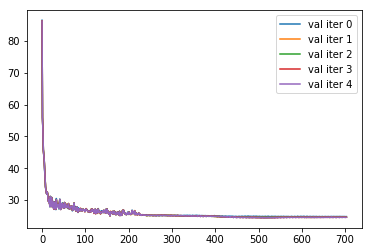

In [34]:
utils.plot_error_on_iterations(history_3, [None, None], [0, 1, 2, 3, 4])

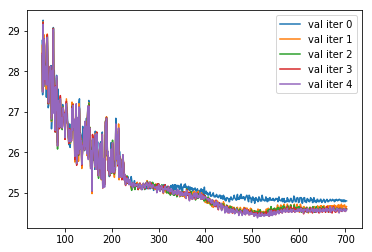

In [35]:
utils.plot_error_on_iterations(history_3, [50, None], [0, 1, 2, 3, 4])

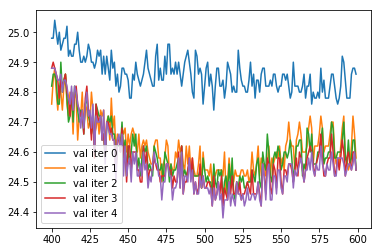

In [36]:
utils.plot_error_on_iterations(history_3, [400, 600], [0, 1, 2, 3, 4])